In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import h5py

path = '/Users/braden/Documents/ProbeTools/Testbed'
os.chdir(path)
print(os.getcwd())

files = [f for f in os.listdir() if 'LP' in f]
files

/Users/braden/Documents/ProbeTools/Testbed


['LP_33-34deg_150V.hdf5']

Vf: 15.90


Text(0.5, 1.0, 'Raw LP Trace')

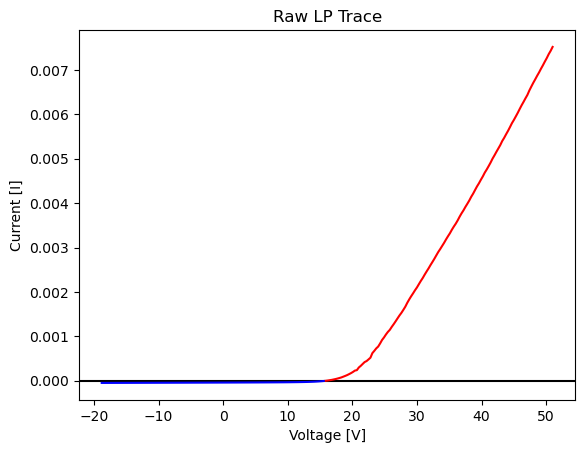

In [31]:
def LP_extract_metadata(file):
    parts = file.split('_')
    bias = int(parts[2].split('V')[0])
    
    split_angle = parts[1][:-3].split('-')
    if len(split_angle) == 1:
        angle = int(split_angle[0])
    elif len(split_angle) == 2:
        angle = int(split_angle[0]) + int(split_angle[1])/10**(len(split_angle[1]))
    else:
        Exception('Unexpected format for angle in file ' + file)
    return angle, bias

file = files[0]

angle, bias = LP_extract_metadata(file)

with h5py.File(file, 'r') as f:
    data = f['/Data'][:]
# Extract raw data
V_raw = data[:,2]
I_raw = -data[:,1]
# Obtain floating voltage
i = np.abs(I_raw).argmin()
Vf = V_raw[i]
print('Vf: %.2f' % Vf)

plt.axhline(0, c='k')
plt.plot(V_raw[:i], I_raw[:i], 'b-')
plt.plot(V_raw[i:], I_raw[i:], 'r-')
plt.xlabel('Voltage [V]')
plt.ylabel('Current [I]')
plt.title('Raw LP Trace')

Text(0.5, 1.0, 'Natural Log of LP Trace')

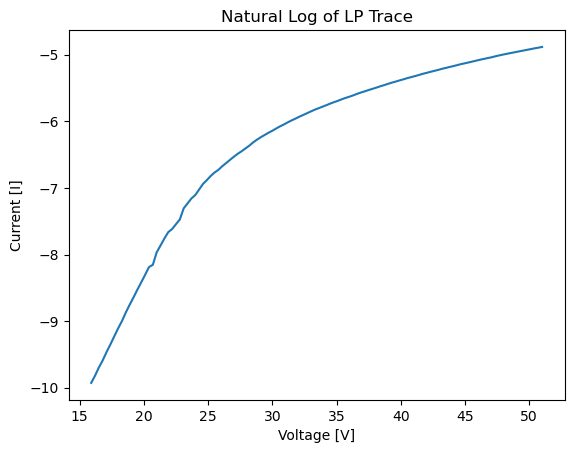

In [33]:
plt.plot(V_raw[i:], np.log(I_raw[i:] - min(I_raw)))
plt.xlabel('Voltage [V]')
plt.ylabel('Current [I]')
plt.title('Natural Log of LP Trace')

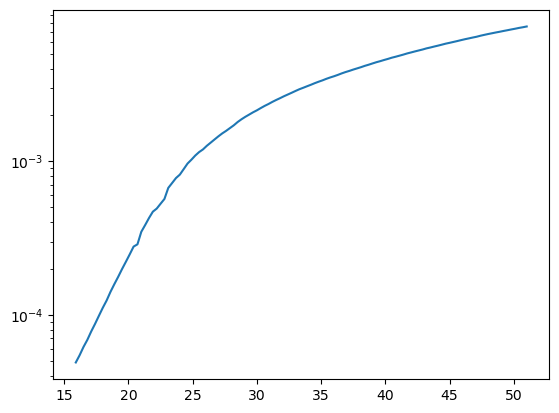

In [23]:
plt.semilogy(V_raw[i:], I_raw[i:] - min(I_raw))

In [40]:
import pymc as pm
import numpy as np

# Use your actual data here
V = V_raw[i:]
logI = np.log(I_raw[i:] - min(I_raw))    # Log of current data with ion saturation subtrated out

# Scale X and Y (z-score standardization)
V_mean = np.mean(V)
V_std = np.std(V)
V_scaled = (V - V_mean) / V_std

logI_mean = np.mean(logI)
logI_scaled = logI - logI_mean  # Center (no need to divide by std here, but you could)

with pm.Model() as model:
    changepoint = pm.Uniform("changepoint", lower=V_scaled.min(), upper=V_scaled.max())
    m1 = pm.Normal("m1", mu=0, sigma=1)
    b1 = pm.Normal("b1", mu=0, sigma=5)
    m2 = pm.Normal("m2", mu=0, sigma=1)
    b2 = pm.Normal("b2", mu=0, sigma=5)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = pm.math.switch(
        V_scaled < changepoint,
        m1 * V_scaled + b1,
        m2 * V_scaled + b2
    )
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=logI_scaled)
    trace = pm.sample(2000, tune=1000, target_accept=0.85, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [changepoint, m1, b1, m2, b2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 246 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [41]:
# Extract posterior samples from trace
changepoint_samples = trace.posterior["changepoint"].values.flatten()
m2_samples = trace.posterior["m2"].values.flatten()

# Unscale changepoint and slope
Vplasma_samples = changepoint_samples * V_std + V_mean
slope_original = m2_samples / V_std
Te_samples = 1.0 / slope_original  # assuming V in volts, Te in eV

# 68% credible intervals:
def ci68(x):
    lower, upper = np.percentile(x, [16, 84])
    return lower, upper

# Calculate means and intervals
Te_mean = np.mean(Te_samples)
Te_lower, Te_upper = ci68(Te_samples)

Vplasma_mean = np.mean(Vplasma_samples)
Vplasma_lower, Vplasma_upper = ci68(Vplasma_samples)

print(f"T_e: {Te_mean:.2f} eV [68% CI: {Te_lower:.2f}, {Te_upper:.2f}] eV")
print(f"V_plasma: {Vplasma_mean:.2f} V [68% CI: {Vplasma_lower:.2f}, {Vplasma_upper:.2f}] V")

T_e: 15.26 eV [68% CI: 14.86, 15.65] eV
V_plasma: 26.40 V [68% CI: 26.10, 26.70] V


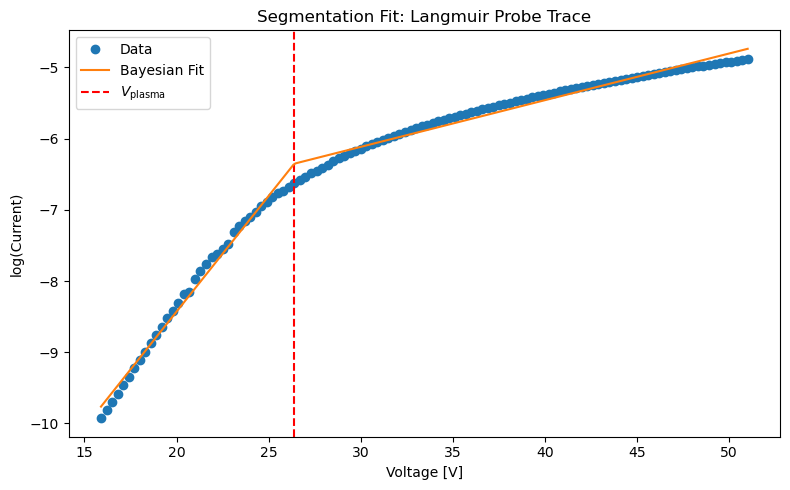

In [42]:
# Get mean params from posterior
m1_mean = trace.posterior['m1'].values.mean()
b1_mean = trace.posterior['b1'].values.mean()
m2_mean = trace.posterior['m2'].values.mean()
b2_mean = trace.posterior['b2'].values.mean()
changepoint_mean_scaled = changepoint_samples.mean()
changepoint_mean = changepoint_mean_scaled * V_std + V_mean

# Prepare piecewise fit in original V
def piecewise_fit(V_points):
    V_s = (V_points - V_mean) / V_std
    fit = np.where(
        V_s < changepoint_mean_scaled,
        m1_mean * V_s + b1_mean,
        m2_mean * V_s + b2_mean
    )
    return fit + logI_mean

# For plotting
V_plot = np.linspace(V.min(), V.max(), 300)
fit_line = piecewise_fit(V_plot)

plt.figure(figsize=(8, 5))
plt.plot(V, logI, 'o', label='Data')
plt.plot(V_plot, fit_line, '-', label='Bayesian Fit', zorder=3)
plt.axvline(Vplasma_mean, color='r', ls='--', label=r'$V_\mathrm{plasma}$')
plt.xlabel('Voltage [V]')
plt.ylabel('log(Current)')
plt.title('Segmentation Fit: Langmuir Probe Trace')
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
import pytensor.tensor as pt

V_mean = np.mean(V)
V_std = np.std(V)
V_scaled = (V - V_mean)/V_std
logI_mean = np.mean(logI)
logI_scaled = logI - logI_mean

window = 0.5  # fixed width in scaled units

with pm.Model() as model:
    Vp = pm.Uniform("Vp", lower=V_scaled.min() + window, upper=V_scaled.max() - window)
    m1 = pm.Normal("m1", mu=0, sigma=1)
    b1 = pm.Normal("b1", mu=0, sigma=2)
    m2 = pm.Normal("m2", mu=0, sigma=1)
    b2 = pm.Normal("b2", mu=0, sigma=2)
    sigma_main = pm.HalfNormal("sigma_main", 0.3)
    sigma_large = 5.0  # Large stddev for downweighting transition region

    # Two predicted values
    left_val  = m1 * V_scaled + b1
    right_val = m2 * V_scaled + b2

    # Make a "left/right" mask in symbolic pytensor:
    is_left  = (V_scaled < (Vp - window))
    is_right = (V_scaled > (Vp + window))
    # In transition region: ~!(is_left | is_right)

    # Now, build a symbolic "prediction" and "sigma" arrays:
    mu = pt.switch(is_left,  left_val,
          pt.switch(is_right, right_val, 0.0))  # 0.0 (won't matter, as its likelihood is downweighted)
    sigma_arr = pt.switch(is_left | is_right, sigma_main, sigma_large)

    pm.Normal("obs", mu=mu, sigma=sigma_arr, observed=logI_scaled)
    trace = pm.sample(1500, tune=1000, target_accept=0.92, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Vp, m1, b1, m2, b2, sigma_main]


Output()

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 148 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Vplasma: 25.03 V [22.53, 27.45] V
T_e: 17.47 eV [16.09, 18.72] eV


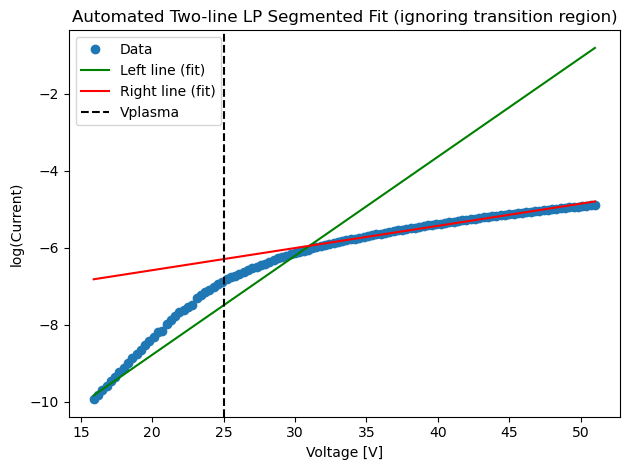

In [50]:
Vp_samps = trace.posterior['Vp'].values.flatten()
Vp_phys = Vp_samps * V_std + V_mean
Vp_mean = np.mean(Vp_phys)
Vp_16, Vp_84 = np.percentile(Vp_phys, [16,84])

m2_samps = trace.posterior['m2'].values.flatten()
m2_phys = m2_samps / V_std
Te_samps = 1.0 / m2_phys
Te_mean = np.mean(Te_samps)
Te_16, Te_84 = np.percentile(Te_samps, [16,84])

print(f"Vplasma: {Vp_mean:.2f} V [{Vp_16:.2f}, {Vp_84:.2f}] V")
print(f"T_e: {Te_mean:.2f} eV [{Te_16:.2f}, {Te_84:.2f}] eV")

# Plot raw data
plt.plot(V, logI, 'o', label="Data")
# Plot mean line fits
plt.plot(V, 
         np.mean(trace.posterior['m1'].values) * (V - V_mean)/V_std + np.mean(trace.posterior['b1'].values) + logI_mean, 
         'g-', label='Left line (fit)')
plt.plot(V, 
         np.mean(trace.posterior['m2'].values) * (V - V_mean)/V_std + np.mean(trace.posterior['b2'].values) + logI_mean, 
         'r-', label='Right line (fit)')
plt.axvline(Vp_mean, color='k', linestyle='--', label='Vplasma')
plt.xlabel("Voltage [V]")
plt.ylabel("log(Current)")
plt.legend()
plt.title("Automated Two-line LP Segmented Fit (ignoring transition region)")
plt.tight_layout()
plt.show()

In [81]:
# Fit the left side to the first 15% of the data
thresh = 0.15
V_left = V[:int(len(V)*thresh)]
logI_left = logI[:int(len(V)*thresh)]
# Fit the right side to the last 30% of the data
thresh = 0.3
V_right = V[-int(len(V)*thresh):]
logI_right = logI[-int(len(V)*thresh):]

with pm.Model() as model:
    # Left branch
    m1 = pm.Normal("m1", mu=0, sigma=2)
    b1 = pm.Normal("b1", mu=0, sigma=4)
    sigma1 = pm.HalfNormal("sigma1", 1)
    pm.Normal("left_obs", mu=m1*V_left + b1, sigma=sigma1, observed=logI_left)

    # Right branch
    m2 = pm.Normal("m2", mu=0, sigma=2)
    b2 = pm.Normal("b2", mu=0, sigma=4)
    sigma2 = pm.HalfNormal("sigma2", 1)
    pm.Normal("right_obs", mu=m2*V_right + b2, sigma=sigma2, observed=logI_right)

    trace = pm.sample(1500, tune=1000, target_accept=0.92, random_seed=42)

m1_samps = trace.posterior['m1'].values.flatten()
b1_samps = trace.posterior['b1'].values.flatten()
m2_samps = trace.posterior['m2'].values.flatten()
b2_samps = trace.posterior['b2'].values.flatten()
Vplasma_samps = (b2_samps - b1_samps) / (m1_samps - m2_samps)
Vp_mean = np.mean(Vplasma_samps)
Vp_16, Vp_84 = np.percentile(Vplasma_samps, [16,84])

# Te from left branch (classic log-linear LP slope):
Te_samps = 1.0 / m1_samps
Te_mean = np.mean(Te_samps)
Te_16, Te_84 = np.percentile(Te_samps, [16,84])

print(f"Vplasma: {Vp_mean:.2f} V [{Vp_16:.2f}, {Vp_84:.2f}] V")
print(f"T_e: {Te_mean:.2f} eV [{Te_16:.2f}, {Te_84:.2f}] eV")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m1, b1, sigma1, m2, b2, sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 23 seconds.


Vplasma: 26.23 V [26.13, 26.32] V
T_e: 2.61 eV [2.59, 2.64] eV


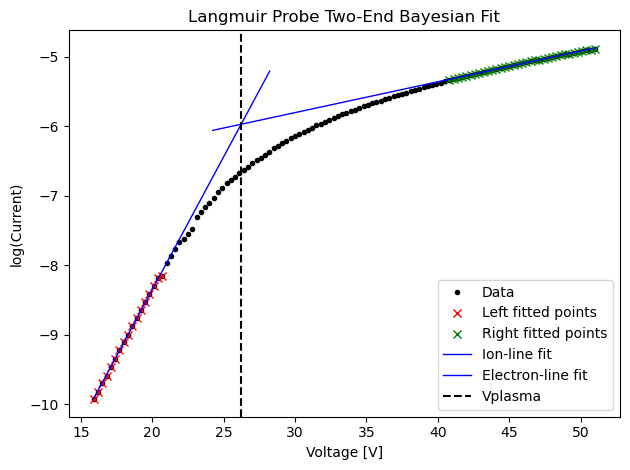

In [82]:


Vp_idx = np.abs(V-Vp_mean).argmin()

plt.plot(V, logI, 'k.', label='Data')
plt.plot(V_left, logI_left, 'rx', label='Left fitted points')
plt.plot(V_right, logI_right, 'gx', label='Right fitted points')

Vleft = np.linspace(min(V_left), Vp_mean+2, 50)
plt.plot(Vleft, m1_samps.mean()*Vleft + b1_samps.mean(), 'b-', lw=1, label='Ion-line fit')

Vright = np.linspace(Vp_mean-2, max(V_right), 50)
plt.plot(Vright, m2_samps.mean()*Vright + b2_samps.mean(), 'b-', lw=1, label='Electron-line fit')
plt.axvline(Vp_mean, color='k', linestyle='--', label='Vplasma')
plt.xlabel("Voltage [V]")
plt.ylabel("log(Current)")
plt.legend()
plt.title('Langmuir Probe Two-End Bayesian Fit')
plt.tight_layout()
plt.show()